# Homework week1

### Import libraries

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import pickle

### Q1. Downloading the data

To download a parquet file from the internet:
1. copy the link from [NY taxi page](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
2. from terminal download files as below

#### Read a Parquet file

In [61]:
df = pd.read_parquet('./data/ny_hire_2021-01.parquet')
print(df.shape)
df.head()

(1154112, 7)


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


A: There are 1154112 records in January dataset.

### Q2. Computing duration

In [20]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [62]:
#calculate duration: columns are already in datetime format so I can compute the difference
df['duration'] = df.dropOff_datetime - df.pickup_datetime

#convert it in minutes: lets apply the minutes conversion to each element in the column
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [63]:
print(df.describe())
df['duration'].mean()

        PUlocationID   DOlocationID      duration
count  195845.000000  991892.000000  1.154112e+06
mean      139.859690     135.898030  1.916722e+01
std        74.991382      80.474902  3.986922e+02
min         1.000000       1.000000  1.666667e-02
25%        75.000000      67.000000  7.766667e+00
50%       143.000000     132.000000  1.340000e+01
75%       206.000000     213.000000  2.228333e+01
max       265.000000     265.000000  4.233710e+05


19.1672240937939

A: Average trip duration in January is 19.16 minutes.

### Data preparation

In [64]:
df.duration.describe(percentiles=[0.95, 0.96, 0.97, 0.98, 0.99]) 

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
96%      5.146667e+01
97%      5.775000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

Most of the data are within one hour. Makes sense to focus on these trips, so lets add some filtering.

In [81]:
df_cleaned = df[(df.duration >= 1) & (df.duration <= 60)]
df_cleaned.shape

(1109826, 8)

About 50k records were dropped.

#### Read function

In [172]:
def read_dataframe(filename):
    """Read dataset in parquet format, compute target variable and remove outliers
    """
    
    #Read the parquet files
    df = pd.read_parquet(filename)

    #calculate duration: columns are already in datetime format so I can compute the difference
    df['duration'] = df.dropOff_datetime - df.pickup_datetime

    #convert it in minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    #remove outliers
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df

### Q3. Missing values

In [82]:
df_cleaned.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [83]:
print("% of NAs on each variable")
df_cleaned.isnull().mean() * 100

% of NAs on each variable


dispatching_base_num        0.000000
pickup_datetime             0.000000
dropOff_datetime            0.000000
PUlocationID               83.527328
DOlocationID               13.327044
SR_Flag                   100.000000
Affiliated_base_number      0.069651
duration                    0.000000
dtype: float64

In [84]:
print("% of NAs in pickup location:", df_cleaned["PUlocationID"].isnull().mean()*100)
print("% of NAs in dropoff location:",df_cleaned["DOlocationID"].isnull().mean()*100)

% of NAs in pickup location: 83.52732770722618
% of NAs in dropoff location: 13.327044059158824


In [85]:
# replace NAs with -1
df_cleaned['PUlocationID'] = df_cleaned['PUlocationID'].fillna("-1")
df_cleaned['DOlocationID'] = df_cleaned['DOlocationID'].fillna("-1")

In [87]:
print("% of NAs on each variable after replacement")
df_cleaned.isnull().mean() * 100

% of NAs on each variable after replacement


dispatching_base_num        0.000000
pickup_datetime             0.000000
dropOff_datetime            0.000000
PUlocationID                0.000000
DOlocationID                0.000000
SR_Flag                   100.000000
Affiliated_base_number      0.069651
duration                    0.000000
dtype: float64

In [94]:
df_cleaned["PUlocationID"].value_counts(normalize=True)

-1      0.835
221.0   0.008
206.0   0.006
129.0   0.005
115.0   0.004
         ... 
111.0   0.000
27.0    0.000
34.0    0.000
2.0     0.000
110.0   0.000
Name: PUlocationID, Length: 262, dtype: float64

A: Fraction of "-1"s in pickup location after filling the NAs is 83%.

### Q4. One-hot encoding

In [97]:
df_cleaned.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

See what categorical and numerical variables we have

In [114]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1109826 non-null  object        
 1   pickup_datetime         1109826 non-null  datetime64[ns]
 2   dropOff_datetime        1109826 non-null  datetime64[ns]
 3   PUlocationID            1109826 non-null  object        
 4   DOlocationID            1109826 non-null  object        
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1109053 non-null  object        
 7   duration                1109826 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 76.2+ MB


In [143]:
#For now now lets just use these simple features to train a model
features_df = df_cleaned[["PUlocationID", "DOlocationID"]].astype(str)
features_df.head()

,PUlocationID,DOlocationID
0,-1,-1
1,-1,-1
3,-1,72.0
4,-1,61.0
5,-1,71.0


Turn into a dictionary and then apply One-Hot Encoding

In [144]:
features_df.iloc[:10].to_dict(orient='records')

[{'PUlocationID': '-1', 'DOlocationID': '-1'},
 {'PUlocationID': '-1', 'DOlocationID': '-1'},
 {'PUlocationID': '-1', 'DOlocationID': '72.0'},
 {'PUlocationID': '-1', 'DOlocationID': '61.0'},
 {'PUlocationID': '-1', 'DOlocationID': '71.0'},
 {'PUlocationID': '-1', 'DOlocationID': '91.0'},
 {'PUlocationID': '-1', 'DOlocationID': '39.0'},
 {'PUlocationID': '-1', 'DOlocationID': '37.0'},
 {'PUlocationID': '-1', 'DOlocationID': '39.0'},
 {'PUlocationID': '-1', 'DOlocationID': '72.0'}]

In [153]:
#apply Vectorizer to all features
train_dicts = features_df.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [152]:
# we can see the feature names that the Vectorizer will use
#dv.feature_names_

In [151]:
print(type(X_train))
print("Matrix dimensions:", X_train.shape)

<class 'scipy.sparse.csr.csr_matrix'>
Matrix dimensions: (1109826, 525)


A: Dimensionality of the matrix (number of columns) is 525.

#### Processing steps into a function

In [176]:
def process_data(df):
    """Process dataset before fitting a model
    """
    
    # replace NAs with -1
    df['PUlocationID'] = df['PUlocationID'].fillna("-1")
    df['DOlocationID'] = df['DOlocationID'].fillna("-1")
    
    #cast as string
    features_df = df[["PUlocationID", "DOlocationID"]].astype(str)
    
    #add more processing if needed
    
    return features_df

### Q5. Training a model

Define target variable to predict

In [154]:
target = 'duration'
y_train = df_cleaned[target].values

In [160]:
X_train.shape, y_train.shape

((1109826, 525), (1109826,))

Train a plain linear regression model with default parameters

In [155]:
#Lets train a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Calculate the RMSE of the model on the training data

In [161]:
#first apply this model to training data
y_pred = lr.predict(X_train)

#evaluate error
mean_squared_error(y_train, y_pred, squared=False) #compute mean squared error

10.5285191072048

A: RMSE on training data is 10.52

Visualize results

/Users/marco.pasin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marco.pasin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


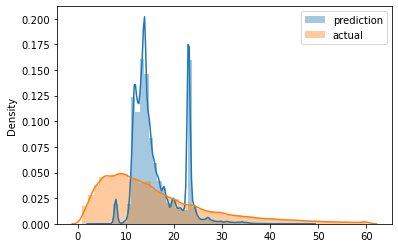

In [162]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

### Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

In [177]:
df_train = read_dataframe('./data/ny_hire_2021-01.parquet')
df_val = read_dataframe('./data/ny_hire_2021-02.parquet')

In [178]:
len(df), len(df_val)

(1109826, 990113)

In [179]:
features_df_val = process_data(df_val)
features_df_val.head()

,PUlocationID,DOlocationID
1,173.0,82.0
2,173.0,56.0
3,82.0,129.0
4,-1,225.0
5,-1,61.0


In [186]:
val_dict = features_df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

target = 'duration'
y_val = df_val[target].values
X_val.shape, y_val.shape

((990113, 525), (990113,))

In [187]:
#apply LR model trained previously, on validation dataset
y_pred = lr.predict(X_val)

#evaluate error
mean_squared_error(y_val, y_pred, squared=False) #we predict on validation dataset now

11.01428314516757

A: RMSE on validation is 11.01

### Save model

In [188]:
with open('models/homework_w1_lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out) #we save 2 things: the dictionary vectorizer and the model; we save it to f_out